# Portfolio Optimization in Python

In [1]:
#import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
%matplotlib inline

## Retrieve data from yahoo finance

In [2]:
assets = ['MSFT', 'GOOG', 'TSLA', 'FB','AAPL']

stock_data = pd.DataFrame()

for a in assets:
    stock_data[a] = web.DataReader(a, 'yahoo' , start = '2017-03-24', end = '2022-03-24')['Adj Close']

stock_data

,MSFT,GOOG,TSLA,FB,AAPL
Date,,,,,
2017-03-24,60.657845,814.429993,52.632000,140.339996,33.196671
2017-03-27,60.769867,819.510010,54.043999,140.320007,33.253311
2017-03-28,60.947216,820.919983,55.490002,141.759995,33.942554
2017-03-29,61.115246,831.409973,55.476002,142.649994,34.018078
2017-03-30,61.339283,831.500000,55.584000,142.410004,33.973236
...,...,...,...,...,...
2022-03-18,300.429993,2736.030029,905.390015,216.490005,163.979996
2022-03-21,299.160004,2729.570068,921.159973,211.490005,165.380005
2022-03-22,304.059998,2805.550049,993.979980,216.649994,168.820007


Text(0, 0.5, '% Change')

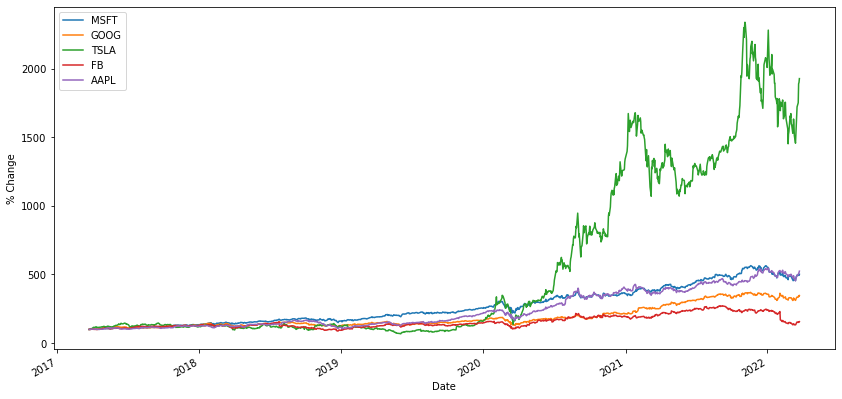

In [3]:
# Normalize and plot data
(stock_data/stock_data.iloc[0]*100).plot(figsize = (14,7))
plt.ylabel('% Change')

## Measuring logarithmic returns

In [4]:
stock_daily_return = np.log(stock_data/stock_data.shift(1))
stock_daily_return

,MSFT,GOOG,TSLA,FB,AAPL
Date,,,,,
2017-03-24,NaN,NaN,NaN,NaN,NaN
2017-03-27,0.001845,0.006218,0.026474,-0.000142,0.001705
2017-03-28,0.002914,0.001719,0.026404,0.010210,0.020515
2017-03-29,0.002753,0.012697,-0.000252,0.006259,0.002223
2017-03-30,0.003659,0.000108,0.001945,-0.001684,-0.001319
...,...,...,...,...,...
2022-03-18,0.017494,0.016220,0.038035,0.040776,0.020703
2022-03-21,-0.004236,-0.002364,0.017268,-0.023367,0.008501
2022-03-22,0.016246,0.027456,0.076083,0.024105,0.020587


In [5]:
# Estimating each security's yearly return
stock_yearly_return = round(stock_daily_return.mean()*250, 2)
stock_yearly_return

MSFT    0.32
GOOG    0.25
TSLA    0.59
FB      0.09
AAPL    0.33
dtype: float64

## Measuring risk

In [6]:
# Estimating each security's risk using the standard deviation (sqrt(250) to annualize results as std is sqrt of var)
stock_yearly_vol = round(stock_daily_return.std()*(250**0.5), 2)
stock_yearly_vol

MSFT    0.28
GOOG    0.28
TSLA    0.61
FB      0.37
AAPL    0.31
dtype: float64

## Create a dictionary with each security risk & return profile

In [7]:
stock_risk_return = pd.DataFrame({'Return': stock_yearly_return, 'Risk': stock_yearly_vol})
stock_risk_return

,Return,Risk
MSFT,0.32,0.28
GOOG,0.25,0.28
TSLA,0.59,0.61
FB,0.09,0.37
AAPL,0.33,0.31


## Markowitz efficient frontier

In [ ]:
#Create a loop with 100000 iterations that will generate random weights and append values in lists
portfolio_returns = []
portfolio_volatilities = []
portfolio_weights = []

for x in range(100000):
    weights = np.random.rand(len(assets))
    weights /= sum(weights)
    portfolio_returns.append(np.dot(weights.T, stock_yearly_return))
    portfolio_volatilities.append(np.dot(weights.T, np.dot(stock_daily_return.cov()*250, weights)))
    portfolio_weights.append(weights)

# Create a dictionary with each combinations return and risk
portfolio_data = pd.DataFrame({'Portfolio Return': portfolio_returns, 'Portfolio Volatility': portfolio_volatilities, 'Portfolio weights': portfolio_weights })
portfolio_data

In [ ]:
# Draw the effcient frontier
portfolio_data.plot(x = 'Portfolio Volatility', y = 'Portfolio Return', kind = 'scatter', figsize = (8, 7))

### Minimum variance portfolio

In [ ]:
min_var_portfolio = portfolio_data.iloc[portfolio_data['Portfolio Volatility'].idxmin()]
min_var_portfolio

### Optimal risky portfolio

In [ ]:
# consider risk-free asset to be 12months US T-bill (https://www.bloomberg.com/markets/rates-bonds/government-bonds/us)
rf = 0.0152

# Find the portfolio with the highest sharpe ratio
opt_risk_portfolio = portfolio_data.iloc[((portfolio_data['Portfolio Return']-rf)/portfolio_data['Portfolio Volatility']).idxmax()]
opt_risk_portfolio

### Capital Allocation Line (CAL)

In [ ]:
x = np.linspace(start=0, stop=0.12, num=100)
y = rf + (opt_risk_portfolio[0]-rf)/opt_risk_portfolio[1] * x

In [ ]:
# Draw the effcient frontier, CML(red), optimal portfolio (red), minimum variance portfolio (yellow)
plt.subplots(figsize = (12, 7))
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.scatter(portfolio_data['Portfolio Volatility'], portfolio_data['Portfolio Return'])
plt.scatter(min_var_portfolio[1], min_var_portfolio[0], marker = 'o' , color = 'y', label='Minimum Variance Portfolio')
plt.scatter(opt_risk_portfolio[1], opt_risk_portfolio[0], marker = 'o', color = 'r', label = 'Optimal Portfolio')
plt.plot(x, y, color = 'red', label = 'CAL')
plt.legend(loc='best')

## CAPM

### Stock beta

In [ ]:
# let the market proxy be the S&P500, import the S&P500 daily prices
market_prices = pd.DataFrame(web.DataReader('^GSPC', 'yahoo', start = '2017-03-24', end = '2022-03-24')['Adj Close'])

# Compute log returns
market_daily_return = np.log(market_prices/market_prices.shift(1))

# Add S&P 500 returns to dataframe
stock_daily_return['S&P 500'] = market_daily_return
stock_daily_return

# Compute covariance matrix
cov_matrix = stock_daily_return.cov()*250
cov_matrix

# Compute beta
stock_beta = round(cov_matrix['S&P 500']/cov_matrix.iloc[5,5], 3)
stock_beta

### Optimal portfolio beta 

In [ ]:
# Drop last row (S&P 500) of stock_beta df to multiply both arrays and round results
round(np.dot(opt_risk_portfolio[2], stock_beta.drop(axis = 0, index = "S&P 500")), 3)